# Introducción a la Estimación de Posición y Orientación de Robots Móviles

El objetivo de este código es el siguiente:

* Aplicar el concepto de cinemática directa para determinar la velocidad del robot a partir de la velocidad de los actuadores.
* Analizar los métodos de integración numérica aplicables a los modelos cinemáticos de robots móviles.
* Comprender la aplicación y utilidad de estas técnicas en el campo de la robótica.
* Avanzar en el proceso de implementar estas técnicas en python.

**IMPORTANTE**: Colocar los archivos `PoseShape*.npz` y `PosePathControl*.npz` en la carpeta de trabajo actual.

En este python notebook se utilizá el modelo cinemático de un **robot diferencial** para transformar las **velocidades de las ruedas** a la **velocidad absoluta** del robot.

<img src="robot.png" width="400">

Importamos las librerías necesarias para desarrollar el código y definimos los parámetros del modelo cinemático del robot.

In [2]:
# Importamos las librerías
import numpy as np
import matplotlib.pyplot as plt
import os

# Radio de la rueda, en m.
r=0.08 

# Distancia entre ruedas, en m.
L=0.21 

 Se define la función `Jcc()` que retorna el Jacobiano de velocidades cuya derivación puede ser encontrada en la literatura, como por ejemplo [aqui](https://www.roboticsbook.org/S52_diffdrive_actions.html). Las funciones `ReadTrackingShape()` y `ReadTrackingPath()` cargarán los datos de velocidad y posición del robot en diferentes escenarios. Las funciones `ReadSensors()` y `GetDeltaT()` retornaran los valores de velocidad angular de las ruedas y periodo de muestreo en una muestra determinada, respectivamente. Finalmente, se crean las funciones `PlotRobotShape()` y `PlotRobotPath()` que servirán para graficar la ruta del robot diferencial en un plot cartesiano XY.

In [3]:
def Jcc(r, L, theta):
  """
  Esta función retorna el Jacobiano de velocidades de un robot con 
  configuración diferencial que transforma la velocidad de las ruedas a
  la velocidad en coordenadas del plano inercial (XY).

  Entradas:
    - r = Radio de la rueda ,en m.

    - L = Distancia entre ruedas, en m.

    - theta = Ángulo de orientación actual, en rad.

  Salida:
    - J = Jacobiano de velocidad, array 3x2.
  """
  # Precálculo
  c, s = np.cos(theta), np.sin(theta)

  # Matriz de rotación
  R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1))) 

  # Jacobanio respecto al robot (fixed frame)
  Jrel = np.array(((r/2, r/2), (0, 0), (-r/L, r/L))) 

  return R.dot(Jrel) # Jacobiano de velocidad

def ReadTrackingShape(data_path):   
  """
  Esta función retorna los datos de posición y velocidad del robot
  en las pruebas de movimientos lineales y rotacionales desacoplados con
  "N" muestras.

  Entradas:
    - data_path = Ruta al archivo .npz de los datos.

  Salida:
    - initial_pose = Posición inicial del robot [x, y, theta], array 3x1.

    - desired_pose = Posición deseada del robot en todo el
                    trayecto [x, y, theta], array 3xN.

    - real_pose = Posición real del robot en todo el
                    trayecto, array 3xN.

    - delta_t = Periodo de muestreo de las velocidades, array 1xN.

    - omega_wheel = Velocidades angulares de las ruedas [wl, wr]
                    (izquierda y derecha), array 2x(N-1).
  """
  # Cargamos los datos
  data=np.load(data_path)

  # Obtenemos las variables
  desired_pose=data['desired_pose']
  delta_t=data['delta_t']
  omega_wheel=data['omega_wheel']
  real_pose=data['real_pose']
  
  # Obtenemos la posición inicial
  initial_pose=real_pose[:,0]

  return initial_pose, desired_pose, delta_t, omega_wheel, real_pose

def ReadTrackingPath(data_path):   

  """
  Esta función retorna los datos de posición y velocidad del robot
  en las pruebas de movimientos controlados.

  Entradas:
    - data_path = Ruta al archivo .npz de los datos.

  Salida:
    - initial_pose = Posición inicial del robot [x, y, theta], array 3x1.

    - desired_path = Ruta de seguimiento deseada [x, y], array Nx2.

    - real_pose_estcontr = Posición real del robot en todo el
                    trayecto con control en base a estimación
                    [x, y, theta], array 3xQ.

    - sensed_pose_estcontr = Posición sensada del robot en todo el
                    trayecto con control en base a estimación
                    [x, y, theta], array 3xQ.

    - omega_wheel_estcontr = Velocidades angulares de las ruedas [wl, wr]
                    (izquierda y derecha) durante el movimiento
                    con control en base a estimación, array 2x(Q-1).

    - real_pose_sencontr = Posición real del robot en todo el
                    trayecto con control en base a medición
                    [x, y, theta], array 3xM.

    - sensed_pose_sencontr = Posición sensada del robot en todo el
                    trayecto con control en base a medición
                    [x, y, theta], array 3xM.

    - omega_wheel_sencontr = Velocidades angulares de las ruedas [wl, wr]
                    (izquierda y derecha) durante el movimiento
                    con control en base a medición, array 2x(M-1).
  """
  # Cargamos los datos
  data=np.load(data_path)

  # Obtenemos las variables
  desired_path=data['desired_path']
  real_pose_estcontr=data['real_pose_estcontr']
  sensed_pose_estcontr=data['sensed_pose_estcontr']
  omega_wheel_estcontr=data['omega_wheel_estcontr']
  real_pose_sencontr=data['real_pose_sencontr']
  sensed_pose_sencontr=data['sensed_pose_sencontr']
  omega_wheel_sencontr=data['omega_wheel_sencontr']
  
  # Obtenemos la posición inicial
  initial_pose=real_pose_estcontr[:,0]

  return initial_pose, desired_path, real_pose_estcontr, sensed_pose_estcontr, omega_wheel_estcontr, real_pose_sencontr, sensed_pose_sencontr, omega_wheel_sencontr

def ReadSensors(omega_wheel, k):
  """
  Esta función retorna las n-ésimas velocidades de las ruedas del arreglo 
  de velocidades de longitud "N".

  Entradas:
    - omega_wheel = Velocidades angulares de las ruedas [wl, wr]
                    (izquierda y derecha), array 2xN.

    - k = Posición de la muestra a extraer, entre el rango de [0, N-1].

  Salida:
    - omega = Velocidades de las ruedas, array 2x1.
  """
  return omega_wheel[:,k]

def GetDeltaT(delta_t, k):
  """
  Esta función retorna el n-ésimo periodo de muestro del arreglo 
  de muestreos de longitud "N".

  Entradas:
    - delta_t = Periodos de muestreo de cada muestra, array 1xN.

    - k = Posición de la muestra a extraer, entre el rango de [0, N-1].

  Salida:
    - dt = Periodo de muestreo, en s.
  """
  return delta_t[k]

def PlotRobotShape(delta_t, desired_pose, real_pose, t, estimated_pose, 
                   position_desired_err, position_estimation_err, 
                   orientation_desired_err, orientation_estimation_err):
  """
  Esta función grafica la posición deseada, real y estimada  del robot 
  en las secuencias de avance y giro, así como los errores de posición y orientación
  entre la ruta deseada y ruta real, y ruta estimada y ruta real. Además, muestra
  la media y desviación estándar de los periodos de muestreo.

  Entradas:
    - delta_t = Periodos de muestreo de cada muestra, array 1xN.

    - desired_pose = Arreglo de posición deseada, 3x(N+1).

    - real_pose = Arreglo de posición real, 3x(N+1).

    - t = Arreglo de tiempo, 1x(N+1).

    - estimated_pose = Arreglo de posición estimada, 3x(N+1).

    - position_desired_err = Arreglo de error entre posiciones 
                              deseadas y reales, 1x(N+1).

    - position_estimation_err = Arreglo de errores entre posiciones 
                              reales y estimadas, 1x(N+1).

    - orientation_desired_err = Arreglo de error entre orientaciones 
                              deseadas y reales, 1x(N+1).

    - orientation_estimation_err = Arreglo de errores entre orientaciones 
                              reales y estimadas, 1x(N+1).

  Salida:
    - Gráficas.
  """
  # Definimos el número de gráficas
  _ , axs = plt.subplots(1,3, figsize=(30,7))

  # Graficamos la trayectoria del robot
  axs[0].set_title('XY Plane (mean dt = '+str(round(np.mean(delta_t),2))+' s, std. dt = '+str(round(np.std(delta_t),2))+' s, time = '+str(round(np.sum(delta_t),2))+' s)')
  axs[0].plot(desired_pose[0,:], desired_pose[1,:], color='red', linestyle='-', label='Desired Trajectory') 
  axs[0].plot(real_pose[0,:], real_pose[1,:], color='blue', linestyle='-', label='Real Trajectory') 
  axs[0].plot(estimated_pose[0,:], estimated_pose[1,:], color='green', linestyle='-.', label='Estimated Trajectory') 
  axs[0].set_ylabel('Y (m)')
  axs[0].set_xlabel('X (m)')
  axs[0].legend(loc='upper right')
  axs[0].grid()

  # Graficamos el error de posición cartesiana
  axs[1].set_title('Position Error')
  axs[1].plot(t, position_desired_err, color='red', linestyle='-', label='Real | Desired')
  axs[1].plot(t, position_estimation_err, color='black', linestyle='-', label='Estimated | Real')
  axs[1].set_ylabel('Error (m)')
  axs[1].set_xlabel('time (s)')
  axs[1].legend(loc='upper left')
  axs[1].grid()

  # Graficamos el error de orientación
  axs[2].set_title('Orientation Error')
  axs[2].plot(t, orientation_desired_err, color='red', linestyle='-', label='Real | Desired')
  axs[2].plot(t, orientation_estimation_err, color='black', linestyle='-', label='Estimated | Real')
  axs[2].set_ylabel('Error (rad)')
  axs[2].set_xlabel('time (s)')
  axs[2].legend(loc='upper left')
  axs[2].grid()

  # Mostramos el gráfico
  plt.show()

def PlotRobotPath(desired_path, t_estcontr, t_sencontr,
                  sensed_pose_estcontr, real_pose_estcontr, estimated_pose_estcontr, pos_est_err_estcontr, or_est_err_estcontr,
                  sensed_pose_sencontr, real_pose_sencontr, estimated_pose_sencontr, pos_est_err_sencontr, or_est_err_sencontr):
  """
  Esta función grafica la ruta deseada, posición real y posición estimada del robot  
  en las secuencias de movimiento combinado, así como los errores de posición y orientación
  entre la ruta estimada y ruta real en ambos ensayos. Además, muestra el error de posición 
  cartesiana final y la media del error de posición durante todo el trayecto.

  Entradas:
    - desired_path = Ruta deseada, 1xQ.

    - t_estcontr = Arreglo de tiempo del primer ensayo, 1xN.

    - t_sencontr = Arreglo de tiempo del segundo ensayo, 1xM.

    - sensed_pose_estcontr = Arreglo de posiciones sensadas del 
                              primer ensayo, 1xN.

    - real_pose_estcontr = Arreglo de posiciones reales del 
                              primer ensayo, 1xN.

    - estimated_pose_estcontr = Arreglo de posiciones estimadas del 
                              primer ensayo, 1xN.

    - pos_est_err_estcontr = Arreglo de errores de posición cartesiana
                              primer ensayo, 1xN.

    - or_est_err_estcontr = Arreglo de errores de orientación
                              primer ensayo, 1xN.

    - sensed_pose_sencontr = Arreglo de posiciones sensadas del 
                              segundo ensayo, 1xM.

    - real_pose_sencontr = Arreglo de posiciones reales del 
                              segundo ensayo, 1xM.

    - estimated_pose_sencontr = Arreglo de posiciones estimadas del 
                              segundo ensayo, 1xM.

    - pos_est_err_sencontr = Arreglo de errores de posición cartesiana
                              segundo ensayo, 1xM.

    - or_est_err_sencontr = Arreglo de errores de orientación
                              segundo ensayo, 1xM.

  Salida:
    - Gráficas.
  """
  # Definimos el número de gráficas
  _ , axs = plt.subplots(1,4, figsize=(30,6.5))

  # Graficamos la trayectoria del robot del primer ensayo
  axs[0].set_title('XY Plane | Estimation based control (final err. = '+str(round(np.linalg.norm(real_pose_estcontr[0:2,-1]-desired_path[-1,:]),2))+' m, time = '+str(round(np.sum(delta_t_estcontr),2))+' s)')
  axs[0].plot(sensed_pose_estcontr[0,:], sensed_pose_estcontr[1,:], color='green', linestyle='none', marker='o', markersize=0.5, markerfacecolor='none', label='Sensed Trajectory') 
  axs[0].plot(real_pose_estcontr[0,:], real_pose_estcontr[1,:], color='red', linestyle='-', label='Real Trajectory') 
  axs[0].plot(estimated_pose_estcontr[0,:], estimated_pose_estcontr[1,:], color='blue', linestyle='-.', label='Estimated Trajectory') 
  axs[0].plot(desired_path[:,0], desired_path[:,1], color='black', linestyle='--', marker='D', markerfacecolor='none', label='Path') 
  axs[0].set_ylabel('Y (m)')
  axs[0].set_xlabel('X (m)')
  axs[0].legend(loc='upper left')
  axs[0].grid()

  # Graficamos la trayectoria del robot del segundo ensayo
  axs[1].set_title('XY Plane | Sensor based control (final err. = '+str(round(np.linalg.norm(real_pose_sencontr[0:2,-1]-desired_path[-1,:]),2))+' m, time = '+str(round(np.sum(delta_t_sencontr),2))+' s)')
  axs[1].plot(sensed_pose_sencontr[0,:], sensed_pose_sencontr[1,:], color='green', linestyle='none', marker='o', markersize=0.5, markerfacecolor='none', label='Sensed Trajectory') 
  axs[1].plot(real_pose_sencontr[0,:], real_pose_sencontr[1,:], color='red', linestyle='-', label='Real Trajectory') 
  axs[1].plot(estimated_pose_sencontr[0,:], estimated_pose_sencontr[1,:], color='blue', linestyle='-.', label='Estimated Trajectory') 
  axs[1].plot(desired_path[:,0], desired_path[:,1], color='black', linestyle='--', marker='D', markerfacecolor='none', label='Path') 
  axs[1].set_ylabel('Y (m)')
  axs[1].set_xlabel('X (m)')
  axs[1].legend(loc='upper left')
  axs[1].grid()

  # Graficamos el error de posición cartesiana
  axs[2].set_title('Estimation Position Error')
  axs[2].plot(t_estcontr, pos_est_err_estcontr, color='red', linestyle='-', label='EBC (mean = '+str(round(np.mean(pos_est_err_estcontr),2))+' m)')
  axs[2].plot(t_sencontr, pos_est_err_sencontr, color='black', linestyle='-', label='SBC (mean = '+str(round(np.mean(pos_est_err_sencontr),2))+' m)')
  axs[2].set_ylabel('Error (m)')
  axs[2].set_xlabel('time (s)')
  axs[2].legend(loc='upper left')
  axs[2].grid()

  # Graficamos el error de orientación
  axs[3].set_title('Estimation Orientation Error')
  axs[3].plot(t_estcontr, or_est_err_estcontr, color='red', linestyle='-', label='EBC (mean = '+str(round(np.mean(or_est_err_estcontr),2))+' rad)')
  axs[3].plot(t_sencontr, or_est_err_sencontr, color='black', linestyle='-', label='SBC (mean = '+str(round(np.mean(or_est_err_sencontr),2))+' rad)')
  axs[3].set_ylabel('Error (rad)')
  axs[3].set_xlabel('time (s)')
  axs[3].legend(loc='upper left')
  axs[3].grid()

  # Mostramos el gráfico
  plt.show()

### Estimación con movimientos lineales y angulares
A continuación, se trabajará con datos de las velocidades de las ruedas adquiridos del robot (ante movimientos repetidos individuales de traslación y rotación). Se utiliza la funcion `ReadTrackingShape()` para obtener la **posición inicial**, **posición deseada**, **periodo de muestreo**, **velocidades sensadas de ruedas** y **posición real** del robot en cada muestra (para mayor detalle, revisar la descripción de la función). Además, se considera que en el instante inicial la posición real del robot e inicial estimada son las mismas.

Primero, trabajamos con el archivo `PoseShape1.npz`.

In [1]:
# Carpeta de trabajo actual
folder_path = os.getcwd() 

# Nombre del archivo
file_name = "PoseShape1.npz" 

# Ruta total del archivo
data_path=os.path.join(folder_path,file_name) 

# Cargamos los datos 
initial_pose, desired_pose, delta_t, omega_wheel, real_pose = ReadTrackingShape(data_path) 

NameError: name 'os' is not defined

Ahora, luego de haber cargado los datos, se le pide completar el código de programación de integración numérica (muestra por muestra) por el **Método de Euler** para la estimación de posición del robot en cada instante de tiempo a partir de las velocidades de las ruedas registradas en `omega_wheel`. Para ello, utilizar las funciones `ReadSensors()` y `GetDeltaT()` que retornan las velocidades de las ruedas y periodo de muestreo, respectivamente, en una muestra determinada que está en el rango [0, N-1].

In [5]:
# Número de muestras
N=omega_wheel.shape[1] 

# Inicializamos la posición actual
current_pose = initial_pose 

# Inicializamos el arreglo de posiciones
estimated_pose = current_pose 

# Inicializamos el arreglo de tiempo
t=[0]

# Integramos numéricamente a través de todos los muestreos
for k in range(N):
    
    # Obtenemos la velocidad de las ruedas
    omega_k = """COMPLETAR"""

    # Obtenemos el tiempo de muestreo
    dt = """COMPLETAR"""

    # Obtenemos la orientación actual
    theta = current_pose[2]

    # Computamos la posición estimada siguiente
    current_pose = current_pose + """COMPLETAR"""

    # Actualizamos el arreglo de tiempo
    t.append(t[k]+dt)

    # Actualizamos el arreglo de posiciones
    estimated_pose=np.column_stack((estimated_pose, current_pose))

Ahora, completar el siguiente código para determinar el error de estimación de posición y orientación a lo largo de todas las muestras.

In [6]:
# Obtenemos las posiciones en los ejes X e Y, y orientación estimadas
x_est = estimated_pose[0,:]
y_est = estimated_pose[1,:]
theta_est = estimated_pose[2,:]

# Obtenemos las posiciones en los ejes X e Y, y orientación reales
x_real = """COMPLETAR"""
y_real = """COMPLETAR"""
theta_real = """COMPLETAR"""

# Obtenemos las posiciones en los ejes X e Y, y orientación deseadas
x_des = """COMPLETAR"""
y_des = """COMPLETAR"""
theta_des = """COMPLETAR"""

# Calculamos los arreglos de errores de posiciones cartesianas
position_desired_err=np.sqrt((x_real-x_des)**2+(x_real-x_des)**2)
position_estimation_err=np.sqrt((x_est-x_real)**2+(y_est-y_real)**2)

# Calculamos los arreglos de errores de orientaciones
orientation_desired_err=np.abs(theta_des-theta_real)
orientation_estimation_err=np.abs(theta_real-theta_est)

Utilizar la función `PlotRobotShape()` para graficar la trayectoria.

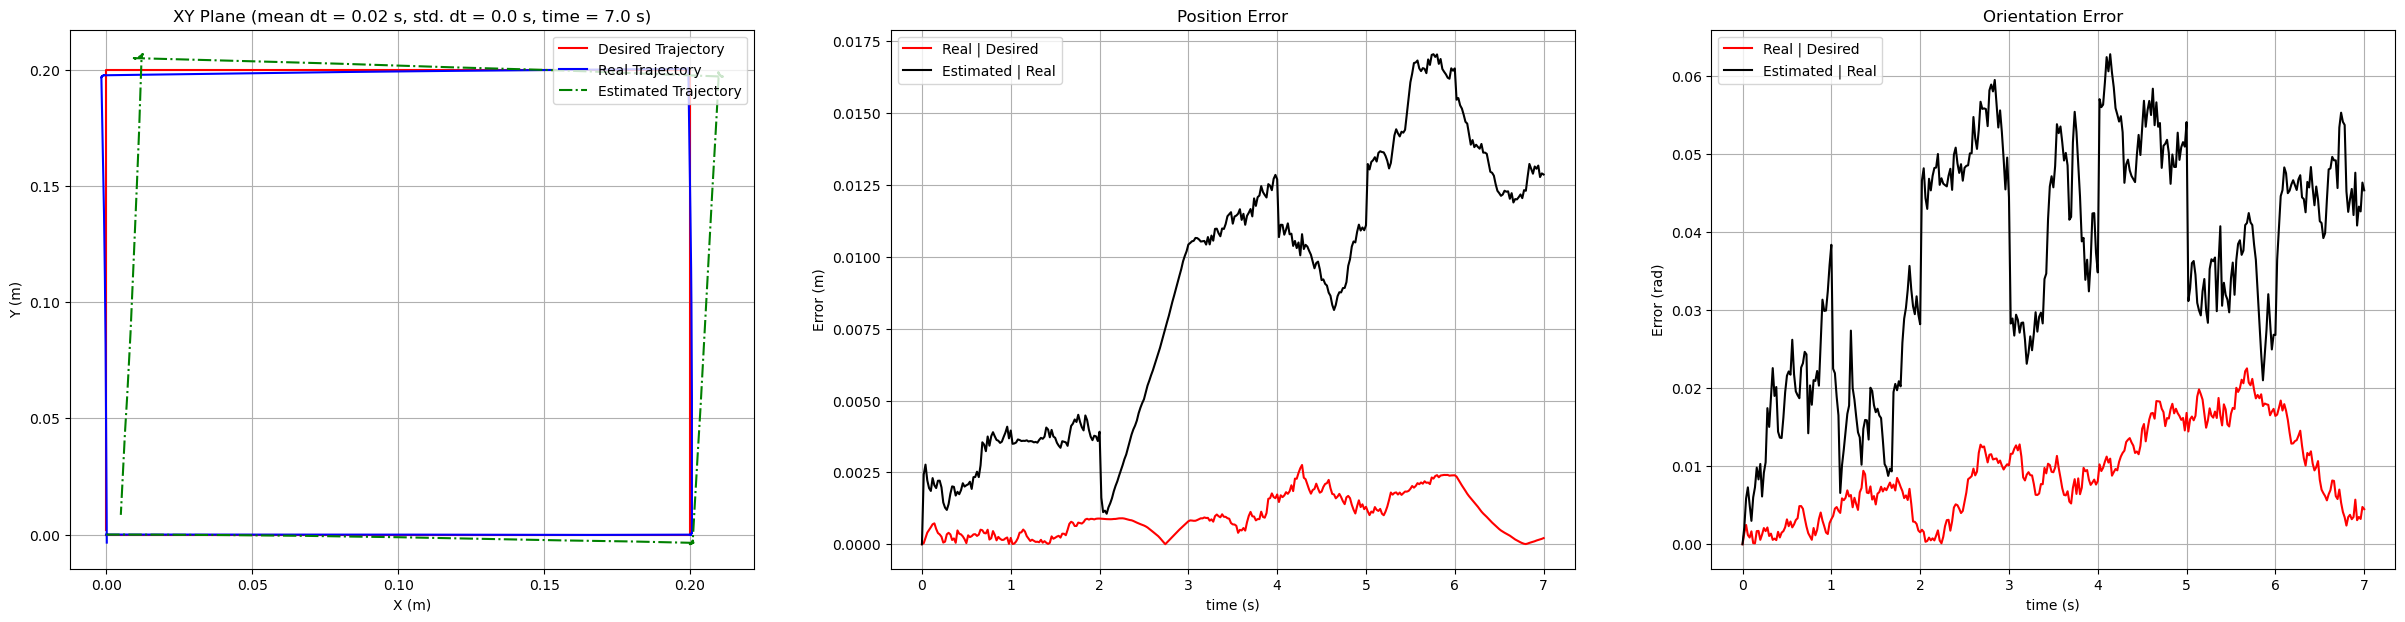

In [7]:
# Mostramos los resultados
PlotRobotShape(delta_t, desired_pose, real_pose, t, estimated_pose, 
                position_desired_err, position_estimation_err, 
                orientation_desired_err, orientation_estimation_err)

Para simplificar el código utilizado, crear la función `DiffDriveEstimatePoseEuler()` que retorne el tiempo total, y los arreglos de tiempo y posición. Además crear la función `CalculatePoseError()` que retorne el error de posición carteriana y orientación entre dos arreglos de posición.

In [8]:
def DiffDriveEstimatePoseEuler(r, L, delta_t, initial_pose, omega_wheel):
  """
  Esta función retorna la posición estimada de un robot diferencial
  a partir de un arreglo de muestras de las velocidades angulares de 
  las ruedas y sus periodos de muestreo asociados.

  Entradas:
    - r = Radio de la rueda ,en m.

    - L = Distancia entre ruedas, en m.

    - delta_t = Periodos de muestreo de cada muestra, array 1xN.
    
    - initial_pose = Posición inicial [x, y, theta], array 3x1.

    - omega_wheel = Arreglo de velocidades [wl, wr]
                    (izquierda y derecha), arreglo 3xN.

  Salida:
    - t = Arreglo de tiempo, arreglo 1x(N+1).
    
    - estimated_pose = Posición estimada, arreglo 3x(N+1).
  """
  
  """COMPLETAR"""

  return t, estimated_pose

def CalculatePoseError(pose_array_0, pose_array_1):
  """
  Esta función retorna los errores de posiciones cartesianas y orientaciones
  entre dos arreglos de tamaño 3xN.

  Entradas:
    - pose_array_0 = Primer arreglo de posiciones [x, y, theta], array 3xN.

    - pose_array_1 = Segundo arreglo de posiciones [x, y, theta], array 3xN.

  Salida:
    - position_err = Error de posiciones cartesianas, array 1xN.
    
    - orientation_err = Error de orientaciones, array 1xN.
  """
  
  """COMPLETAR"""

  return position_err, orientation_err

Ahora probamos el codigo completo con las funciones desarrolladas.

In [ ]:
# Cargamos los datos
"""COMPLETAR"""

# Estimamos la posición del robot
t, estimated_pose = DiffDriveEstimatePoseEuler("""COMPLETAR""")

# Calculamos el error de posición entre la trajectoria deseada y real
position_desired_err, orientation_desired_err = CalculatePoseError("""COMPLETAR""")

# Calculamos el error de posición entre la trajectoria real y estimada
position_estimation_err, orientation_estimation_err = CalculatePoseError("""COMPLETAR""")

# Mostramos los resultados
PlotRobotShape(delta_t, desired_pose, real_pose, t, estimated_pose, 
                position_desired_err, position_estimation_err, 
                orientation_desired_err, orientation_estimation_err)

**Observación**: Se puede apreciar que la trayectorial deseada, real y estimada son diferentes. Esto ocurre debido al error en el accionamiento de los actuadores, es decir, a la imperfección de los actuadores para ejecutar una señal de control específica. Por otra parte, el ruido en los sensores de las ruedas genera una desviación en los valores de velocidad, lo que genera la desviación en la estimación de la posición con respecto a la posición real. Así, el error presente en la estimación de posición ocurre debido a diferentes factores, y para analizar los efectos de estos factores en el resultados de los algoritmos de estimación numérica, se tienen los siguientes datos con sus respectivas variaciones en los parámetros del robot:
- `PoseShape2.npz`: Periodo de muestreo.
- `PoseShape3.npz`: Tiempo de movimiento total.
- `PoseShape4.npz`: Ruido en los actuadores y sensores.

Se le pide analizar los datos utilizando los códigos desarrollados previamente.

In [ ]:
# Escriba aquí su código

"""COMPLETAR"""

**Preguntas de Análisis**: ¿Cuál es la causa del incremento del error de estimación en los datos registrados en `PoseShape5.npz`? ¿Qué otro factor podría aumentar el error en la estimación?

`hint: Analizar el pseudocodigo de integración numérica y ver qué parámetros del modelo no se han abordado ni modificado en los grupos de datos anteriores.`

### Estimación con movimientos combinados
Luego de trabajar con secuencias de movimiento independientes, se trabajará con secuencias que combinanan traslación y rotación. Los datos a analizar son los obtenidos al aplicar un controlador _Pure Pursuit_ en un robot diferencial para seguir una trajectoria y llegar a un punto objetivo. Se realizaron dos ensayos en cada prueba donde se realizaba el control basandose en la posición obtenida por un algoritmo de estimación de posición, y basandose en la posición medida por un sensor de posición con un ruido determinado. Utilizar la funcion `ReadTrackingPath()` para obtener la **posición inicial**, **ruta deseada**, **posición real**, **velocidades sensadas de ruedas** y **posición sensada** del robot en ambos ensayos y en cada prueba (para mayor detalle, revisar la descripción de la función). Además, se considera que en el instante inicial la posición real del robot e inicial estimada son las mismas. Cabe resaltar que se utilizó un **periodo de muestreo de 0.01 s** para medir las velocidades de las ruedas y la posición del robot para todas las pruebas y ensayos.

Utilizando las funciones desarrolladas previamente, completar el código y mostrar los resultados con los datos registrados en `PosePathControl1.npz`

In [10]:
# Cargamos los datos
folder_path = os.getcwd() 
file_name = "PosePathControl1.npz" 
data_path=os.path.join(folder_path,file_name) 
initial_pose, desired_path, real_pose_estcontr, sensed_pose_estcontr, omega_wheel_estcontr, real_pose_sencontr, sensed_pose_sencontr, omega_wheel_sencontr = ReadTrackingPath(data_path)

# Periodo de muestreo
T = """COMPLETAR"""

# Generamos el arreglo de periodos de muestreo de ambos ensayos
delta_t_estcontr = np.full((omega_wheel_estcontr.shape[1]),T)
delta_t_sencontr = np.full((omega_wheel_estcontr.shape[1]),T)

# Estimamos la posición del robot de ambos ensayos
t_estcontr, estimated_pose_estcontr = DiffDriveEstimatePoseEuler("""COMPLETAR""", """COMPLETAR""", delta_t_estcontr, initial_pose, omega_wheel_estcontr)
t_sencontr, estimated_pose_sencontr = DiffDriveEstimatePoseEuler("""COMPLETAR""", """COMPLETAR""", delta_t_sencontr, initial_pose, omega_wheel_sencontr)

# Determinamos el error entre la posición estimada y real en ambos ensayos
pos_est_err_estcontr, or_est_err_estcontr = CalculatePoseError("""COMPLETAR""", """COMPLETAR""")
pos_est_err_sencontr, or_est_err_sencontr = CalculatePoseError("""COMPLETAR""", """COMPLETAR""")

Utilizar la función `PlotRobotPath()` para graficar la trayectoria.

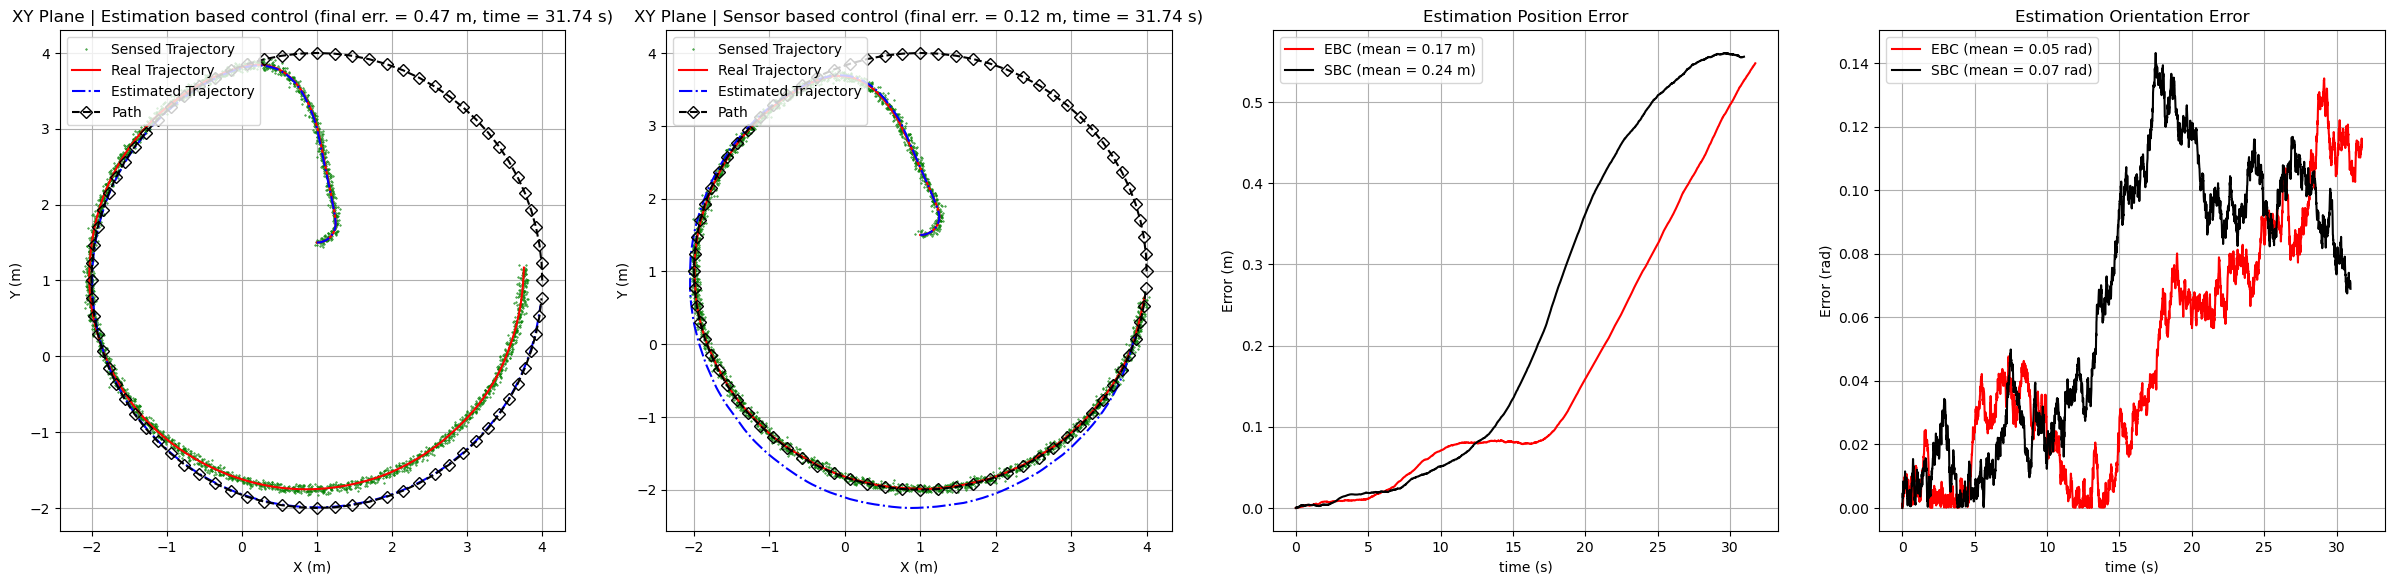

In [11]:
# Mostramos los resultados
PlotRobotPath(desired_path, t_estcontr, t_sencontr,
                sensed_pose_estcontr, real_pose_estcontr, estimated_pose_estcontr, pos_est_err_estcontr, or_est_err_estcontr,
                sensed_pose_sencontr, real_pose_sencontr, estimated_pose_sencontr, pos_est_err_sencontr, or_est_err_sencontr)

Utilizando los códigos anteriores se le pide analizar los resultados de las pruebas en los otros datos `PosePathControl*.npz`

In [ ]:
# Escriba aquí su código

"""COMPLETAR"""

Responder las siguientes preguntas:
- ¿Qué diferencia hay al utilizar un control basado en la posición estimada y otro basado en la posición medida?
- ¿Hay alguna diferencia en el error de posición estimada y real a lo largo de toda la trayectoria en ambos ensayos? ¿Por qué?
- ¿Qué método de control es el mas conveniente? ¿Qué pasaría si el sensor de posición tuviese un periodo de muestreo mucho mayor en ambos ensayos?
- ¿Cómo podría mejorarse la estimación y control utilizando únicamente sensores de velocidad en cada rueda?

Finalmente, se le solicita:
- Desarrollar un función llamada `DiffDriveEstimatePoseBilineal()` que utilice el método bilineal para integrar numéricamente la velocidad y comparar los resultados con el método de Euler.
- Para la primera parte del notebook: 
    1. Derivar la posición deseada y posición real para obtener las velocidades absolutas en cada caso utlizando la función `np.diff()`.
    2. Transformar el vector de velocidades absolutas a velocidades angulares de las ruedas con la matrix inversa del Jacobiano en cada caso, utilizar `np.linalg.pinv()` para calcular la inversa de una matriz no cuadrada.
    3. Obtener el arreglo de errores entre las velocidades deseadas y reales de las ruedas, y arreglo entre velocidades reales y sensadas de las ruedas.
    4. Graficar el histograma para cada arreglo y comentar lo observado.
    5. Responder: ¿Qué tipo de curva es la mostrada en ambos histogramas? ¿Se pueden hallar sus características?
- Para la segunda parte del notebook: 
    1. Importar la librería `scipy` en la primera parte del código.
    2. Averiguar el funcionamiento de la función `scipy.signal.medfilt()` y aplicarla a cada componente de la posición sensada individualmente con `kernel_size=3`.
    3. Graficar la trayectoria con la nueva posición sensada filtrada y comentar lo observado.
    4. Modificar el valor `kernel_size` y comentar lo observado.
    5. Responder: ¿Es posible mejorar el control por sensor aplicando un filtro a la señal obtenida? ¿Cuál sería la desventaja?